<a href="https://colab.research.google.com/github/tharleshenriqye/LinearRegress-o/blob/main/Projeto_Final_ReconhecimentoFacial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install deepface
!pip install mtcnn deepface scikit-learn pillow joblib matplotlib

import zipfile
import os
import numpy as np
from mtcnn.mtcnn import MTCNN
from PIL import Image
from sklearn.preprocessing import LabelEncoder, Normalizer
from sklearn.svm import SVC
import joblib
from deepface import DeepFace
import matplotlib.pyplot as plt


In [2]:
# 1. Extração do dataset (se não extraído)
zip_path = "/content/LFW.zip"
extract_path = "/content/lfw"
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Dataset extraído com sucesso.")

# Caminho do dataset ajustado para a estrutura LFW-deepfunneled
dataset_path = "/content/lfw/lfw-deepfunneled/lfw-deepfunneled"
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"Diretório {dataset_path} não encontrado. Verifique a extração do ZIP.")
if not os.path.isdir(dataset_path):
    raise NotADirectoryError(f"{dataset_path} não é um diretório. Verifique o caminho.")
print("Subpastas encontradas:", os.listdir(dataset_path)[:5])

Subpastas encontradas: ['Tippi_Hedren', 'Nate_Huffman', 'Peter_Greenspun', 'Dennis_Erickson', 'Jerry_Oliver']


In [3]:
# 2. Detecção e recorte de faces com MTCNN
detector = MTCNN()

def extract_face(filename, required_size=(160, 160)):
    image = Image.open(filename).convert('RGB')
    pixels = np.asarray(image)
    results = detector.detect_faces(pixels)
    if len(results) == 0:
        return None
    x1, y1, width, height = results[0]['box']
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    face = pixels[y1:y2, x1:x2]
    image = Image.fromarray(face).resize(required_size)
    return np.asarray(image)

In [4]:
# 3. Carregar dataset (limitado para teste rápido)
def load_dataset(directory, limit_people=20, images_per_person=5):
    X, y = [], []
    people = [p for p in os.listdir(directory) if os.path.isdir(os.path.join(directory, p))][:limit_people]
    for person in people:
        folder = os.path.join(directory, person)
        images = [f for f in os.listdir(folder) if f.endswith(('.jpg', '.jpeg', '.png'))][:images_per_person]
        for filename in images:
            path = os.path.join(folder, filename)
            face = extract_face(path)
            if face is not None:
                X.append(face)
                y.append(person)
    return np.array(X), np.array(y)

faces, labels = load_dataset(dataset_path)
print(f"Dataset carregado: {faces.shape} faces, {len(np.unique(labels))} pessoas.")

Dataset carregado: (31, 160, 160, 3) faces, 20 pessoas.


In [5]:
# 4. Gerar embeddings com FaceNet via DeepFace
def get_embedding(face_pixels):
    face_pixels = face_pixels.astype('uint8')
    embedding = DeepFace.represent(face_pixels, model_name="Facenet", detector_backend="skip")[0]["embedding"]
    return np.array(embedding)

embeddings = np.array([get_embedding(face) for face in faces])
print(f"Embeddings gerados: {embeddings.shape}")

Embeddings gerados: (31, 128)


In [6]:
# 5. Normalização e codificação de labels
in_encoder = Normalizer(norm='l2')
embeddings = in_encoder.transform(embeddings)
out_encoder = LabelEncoder()
labels_enc = out_encoder.fit_transform(labels)

In [7]:
# 6. Treinar classificador SVM
classifier = SVC(kernel='linear', probability=True)
classifier.fit(embeddings, labels_enc)
print("Classificador SVM treinado.")

# Salvar modelos (opcional)
joblib.dump(classifier, "svm_facenet.joblib")
joblib.dump(out_encoder, "label_encoder.joblib")
joblib.dump(in_encoder, "normalizer.joblib")

Classificador SVM treinado.


['normalizer.joblib']

In [8]:
# 7. Função de predição com visualização
def recognize_and_visualize_face(image_path, classifier, out_encoder, in_encoder):
    # Carregar e processar a imagem
    face = extract_face(image_path)
    if face is None:
        print("Nenhuma face detectada")
        return

    # Gerar embedding e predição
    emb = get_embedding(face)
    emb = in_encoder.transform([emb])
    yhat_class = classifier.predict(emb)
    yhat_prob = classifier.predict_proba(emb)
    class_index = yhat_class[0]
    class_probability = yhat_prob[0, class_index] * 100
    predict_name = out_encoder.inverse_transform([class_index])[0]

    # Exibir a imagem com a predição
    plt.figure(figsize=(6, 6))
    plt.imshow(face)
    plt.title(f"Pessoa: {predict_name}\nConfiança: {class_probability:.2f}%", fontsize=12)
    plt.axis('off')  # Remover eixos
    plt.show()

    return f"Pessoa reconhecida: {predict_name} (Confiança: {class_probability:.2f}%)"

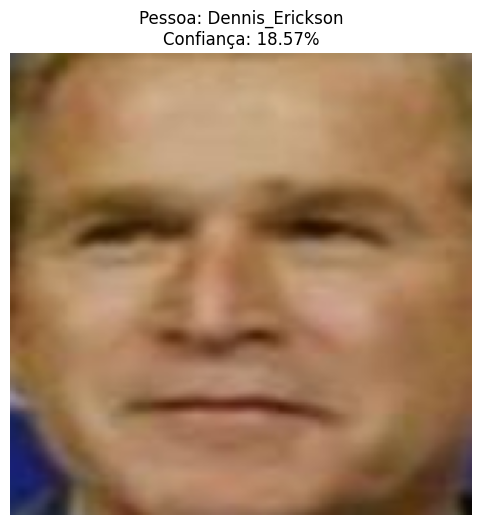

Pessoa reconhecida: Dennis_Erickson (Confiança: 18.57%)


In [9]:
# 8. Teste com uma imagem qualquer
test_image_path = os.path.join(dataset_path, "George_W_Bush", "George_W_Bush_0001.jpg")
result = recognize_and_visualize_face(test_image_path, classifier, out_encoder, in_encoder)
print(result)

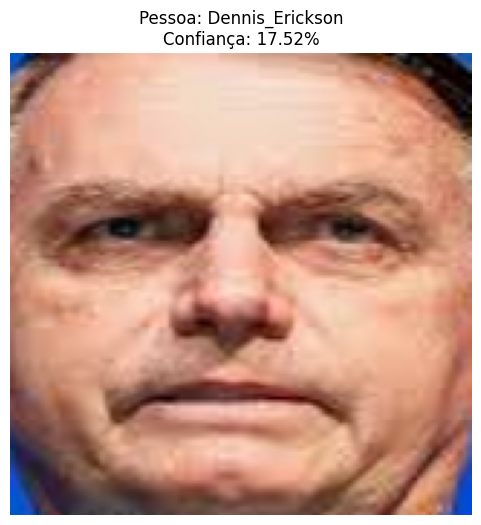

Pessoa reconhecida: Dennis_Erickson (Confiança: 17.52%)


In [10]:
# 8. Teste
test_image_path = os.path.join(dataset_path, "George_W_Bush", "/content/Image_01.jpeg")
result = recognize_and_visualize_face(test_image_path, classifier, out_encoder, in_encoder)
print(result)